# Прогнозирование рейтинга отеля на Booking

# 0. Подготовка к работе

In [664]:
# установка инструмента для анализа отзывов
#!pip install nltk

In [665]:
# импортируем необходимые библиотеки
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import category_encoders as ce
from sklearn import preprocessing

# инструмент для анализа отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Загружаем инструмент для разбивки данных:
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alpis\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [666]:
RANDOM_SEED = 42

In [667]:
# зафиксируем версию пакетов для воспроизводимости кода
!pip freeze > requirements.txt

# 1. Загрузка и объединение данных

*Ссылка на файлы для соревнования:* https://www.kaggle.com/competitions/sf-booking/data

In [668]:
#INPUT_DIR = '/kaggle/input/sf-booking/'
#train_data = pd.read_csv(INPUT_DIR+'/hotels_train.csv') # набор данных для обучения
#test_data = pd.read_csv(INPUT_DIR+'hotels_test.csv') # набор данных для оценки качества
#sample_submission = pd.read_csv(INPUT_DIR+'/submission.csv') # файл сабмишна

In [669]:
INPUT_DIR = 'booking_data'
train_data = pd.read_csv(INPUT_DIR+'/hotels_train.csv') # набор данных для обучения
test_data = pd.read_csv(INPUT_DIR+'/hotels_test.csv') # набор данных для оценки качества
sample_submission = pd.read_csv(INPUT_DIR+'/submission.csv') # файл сабмишна

In [670]:
train_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [671]:
test_data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [672]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [673]:
# для корректной обработки признаков объединяем train и test в единый dataframe
train_data['sample'] = 1 # помечаем где у нас трейн
test_data['sample'] = 0 # помечаем где у нас тест
test_data['reviewer_score'] = 0 # в тестовых данных отсутствует признак reviewer_score. Значения этого признака мы его должны предсказать. Временно заполняем признак нулями

hotels = test_data.append(train_data, sort=False).reset_index(drop=True)

C:\Users\alpis\AppData\Local\Temp\ipykernel_18400\567094796.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = test_data.append(train_data, sort=False).reset_index(drop=True)


In [674]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Первичный анализ данных показал наличие пропусков в признаках lat (широта отеля) и lng (долгота отеля). Учтём это в дальнейшей работе над признаками.

# 2. Работа с пропусками

In [677]:
# определим процент пропущенных значений в данных
cols_null_percent = hotels.isnull().mean()*100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_null_percent

hotel_address                                 0.000000
additional_number_of_scoring                  0.000000
review_date                                   0.000000
average_score                                 0.000000
hotel_name                                    0.000000
reviewer_nationality                          0.000000
negative_review                               0.000000
review_total_negative_word_counts             0.000000
total_number_of_reviews                       0.000000
positive_review                               0.000000
review_total_positive_word_counts             0.000000
total_number_of_reviews_reviewer_has_given    0.000000
tags                                          0.000000
days_since_review                             0.000000
lat                                           0.633655
lng                                           0.633655
sample                                        0.000000
reviewer_score                                0.000000
dtype: flo

In [678]:
# для удобства заполнения пропусков в признаках lat и lng извлечём признаки страны и города из признака hotel_address  
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1]=='Kingdom' else x.split()[-1])
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1]=='Kingdom' else x.split()[-2])

In [679]:
# Получим список уникальных городов, в которых содержатся пропуски координат отелей
lat_mask = hotels['lat'].isnull()
lng_mask = hotels['lng'].isnull()

null_city = list(set(hotels[lat_mask]['hotel_city']))

display(f'Количество уникальных значений городов, для которых обнаружены пропуски: {len(null_city)}')
print(null_city)

'Количество уникальных значений городов, для которых обнаружены пропуски: 3'

['Barcelona', 'Vienna', 'Paris']


In [680]:
# после обработки признак hotel_address можно удалить
hotels.drop('hotel_address', axis=1, inplace=True)

In [681]:
list(lat_mask.index) == list(lng_mask.index) # если в строке пропущена одна координата, то в этой же строке пропущена вторая

True

In [682]:
# создадим словарь с модальными значениями координат по каждому городу с пропусками в данных
lat_dict = {}
lng_dict = {}

for city in null_city:
    lat_dict[city] = lat_dict.get(city, hotels[hotels['hotel_city']==city]['lat'].mode()[0])
    lng_dict[city] = lng_dict.get(city, hotels[hotels['hotel_city']==city]['lng'].mode()[0])

In [683]:
# заполняем пропуски в lat и lng модальными значениями для конкретного города
for city in null_city:
    hotels.loc[(lat_mask & (hotels['hotel_city'] == city)), 'lat'] = lat_dict[city]
    hotels.loc[(lng_mask & (hotels['hotel_city'] == city)), 'lng'] = lng_dict[city]

In [684]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_date                                 515738 non-null  object 
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

Пропусков в данных нет, приступаем к следующему шагу обработки.

# 3. Создание новых признаков

In [686]:
# добавим признаки населения страны (country_population), населения города (city_population) и долю людей, проживающих в городе от общего кол-ва нареления страны (city_to_country_share)
country_population = {
    'United Kingdom':67_108_596,
    'Spain':47_344_649,
    'France':67_413_000,
    'Netherlands':17_645_800,
    'Austria':9_027_999,
    'Italy':59_257_566
    }

city_population = {
    'London':8_961_989,
    'Barcelona':1_636_732,
    'Paris':2_148_327,
    'Amsterdam':872_757,
    'Vienna':1_897_491,
    'Milan':1_378_689
    }

hotels['country_population'] = hotels['hotel_country'].map(country_population)
hotels['city_population'] = hotels['hotel_city'].map(city_population)
hotels['city_to_country_share'] = hotels['city_population'] / hotels['country_population'] 

In [687]:
# из признака даты извлечём месяц, когда был составлен отзыв
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_month'] = hotels['review_date'].dt.month

In [688]:
hotels.drop('review_date', axis=1, inplace=True) #удаляем признак после извлечения из него полезной информации

In [689]:
# анализируем отзывы пользователей
sent_analyzer = SentimentIntensityAnalyzer()
hotels['positive_rev_score'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
hotels['negative_rev_score'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

In [690]:
# под каждую оценку создадим отдельный признак
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['positive_rev_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['negative_rev_score'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

In [691]:
# удаляем признаки после извлечения из них полезной информации
hotels.drop(['positive_review', 'negative_review', 'positive_rev_score', 'negative_rev_score'], axis=1, inplace=True)

In [692]:
# выполним анализ тегов
tags_dict = {} 

def unique_tags(tags_list):
    tags_list = tags_list[3:-3].split(" ', ' ")
    for tag in tags_list:
        tags_dict[tag] = tags_dict.get(tag, 0) + 1
        

hotels['tags'].apply(unique_tags)

len(tags_dict)

2428

In [693]:
# выведем топ 20 самых популярных тегов
top20_uniq_tags = pd.DataFrame(tags_dict, index=['count']).transpose().sort_values(by='count', ascending=False)[:20]
top20_uniq_tags

,count
Leisure trip,417778
Submitted from a mobile device,307640
Couple,252294
Stayed 1 night,193645
Stayed 2 nights,133937
Solo traveler,108545
Stayed 3 nights,95821
Business trip,82939
Group,65392
Family with young children,61015


In [694]:
hotels['tags'] = hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' "))

# закодируем признак tags
for tag in list(top20_uniq_tags.index):
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

In [695]:
hotels.drop('tags', axis=1, inplace=True) #удаляем признак после извлечения из него полезной информации

In [696]:
# работа со странами рецензентов
top10_countries = hotels['reviewer_nationality'].value_counts()[:10]
top10_countries

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
Name: reviewer_nationality, dtype: int64

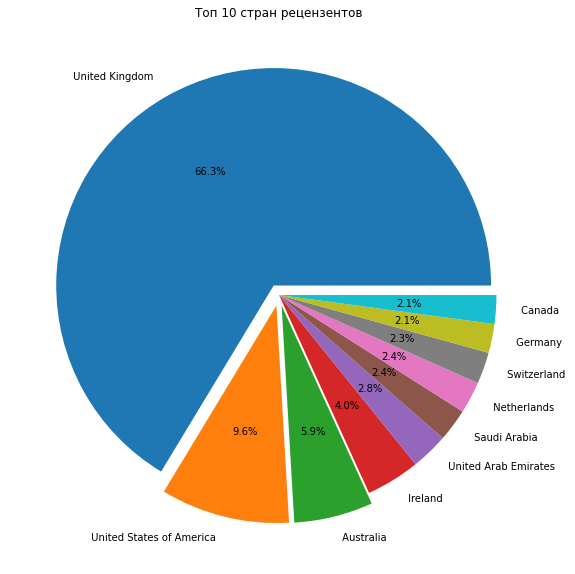

In [697]:
fig, ax = plt.subplots(figsize = (10, 10))

ax.pie(
    top10_countries,
    labels = top10_countries.index,
    autopct='%.1f%%',
    explode = [0.05, 0.05, 0.05, 0, 0, 0, 0, 0, 0, 0]
)
fig.patch.set_facecolor('white')
ax.set_title('Топ 10 стран рецензентов')

plt.show()

In [698]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in top10_countries.index else 'other')

In [699]:
# перевод в int числа дней с момента выгрузки данных
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

# 4. Отбор признаков

In [700]:
# признак hotel_name не получится использовать для получения полезной информации,  поэтому избавимся от него
hotels.drop('hotel_name', axis=1, inplace=True)

In [701]:
object_columns = [x for x in hotels.columns if hotels[x].dtypes == 'object']
object_columns

['reviewer_nationality', 'hotel_country', 'hotel_city']

In [702]:
# оценим оставшиеся признаки типа object
display(hotels['reviewer_nationality'].unique())
display(hotels['hotel_country'].unique())
display(hotels['hotel_city'].unique())

array([' United Kingdom ', 'other', ' United States of America ',
       ' Netherlands ', ' Ireland ', ' Canada ', ' Australia ',
       ' Saudi Arabia ', ' Germany ', ' United Arab Emirates ',
       ' Switzerland '], dtype=object)

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

In [703]:
# закодируем признаки типа object при помощи двоичного кодирования
hotels = pd.get_dummies(hotels, columns=object_columns)

In [704]:
# выполним нормализацию данных методом RobustScaler

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(hotels.columns)

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
hotels_r = r_scaler.fit_transform(hotels)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_r = pd.DataFrame(hotels, columns=col_names)

In [705]:
hotels_r.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Milan,hotel_city_Paris,hotel_city_Vienna
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,49.432405,2.893527,0.749999,...,0.072143,0.110936,0.116627,0.508594,0.110936,0.116627,0.508594,0.072143,0.116199,0.075502
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,3.460258,4.667536,0.433014,...,0.258725,0.314053,0.320976,0.499927,0.314053,0.320976,0.499927,0.258725,0.320463,0.264199
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.214662,-0.143372,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.019886,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,51.516288,4.841163,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [706]:
list(hotels_r.columns)

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'lat',
 'lng',
 'sample',
 'reviewer_score',
 'country_population',
 'city_population',
 'city_to_country_share',
 'review_month',
 'p_neg',
 'p_neu',
 'p_pos',
 'p_compound',
 'n_neg',
 'n_neu',
 'n_pos',
 'n_compound',
 'Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'reviewer_nationality_ Australia ',
 'reviewer_nationality_ Canada ',
 'reviewer_nationality_ Germany ',
 'review

In [707]:
num_cols = [
    'additional_number_of_scoring', 'review_total_negative_word_counts', 
    'total_number_of_reviews', 'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given', 'days_since_review', 
    'country_population', 'city_population', 'city_to_country_share', 
    'p_neg', 'p_neu', 'p_pos', 'p_compound', 'n_neg', 'n_neu', 'n_pos', 
    'n_compound'
    ]

cat_cols = [
    'average_score', 'lat', 'review_month', 
    'Leisure trip', 'Submitted from a mobile device', 'Couple', 'Stayed 1 night',
    'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip',
    'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room',
    'Standard Double Room', 'Superior Double Room',
    'Family with older children', 'Deluxe Double Room',
    'Double or Twin Room', 'Stayed 5 nights',
    'Standard Double or Twin Room', 'Classic Double Room',
    'reviewer_nationality_ Australia ', 'reviewer_nationality_ Canada ', 
    'reviewer_nationality_ Germany ', 'reviewer_nationality_ Ireland ', 
    'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Saudi Arabia ',
    'reviewer_nationality_ Switzerland ',
    'reviewer_nationality_ United Arab Emirates ',
    'reviewer_nationality_ United Kingdom ',
    'reviewer_nationality_ United States of America ',
    'reviewer_nationality_other', 'hotel_country_Austria',
    'hotel_country_France', 'hotel_country_Italy',
    'hotel_country_Netherlands', 'hotel_country_Spain',
    'hotel_country_United Kingdom', 'hotel_city_Amsterdam',
    'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Milan',
    'hotel_city_Paris', 'hotel_city_Vienna'
    ]

In [708]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
train_data = hotels_r.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_r.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<AxesSubplot:>

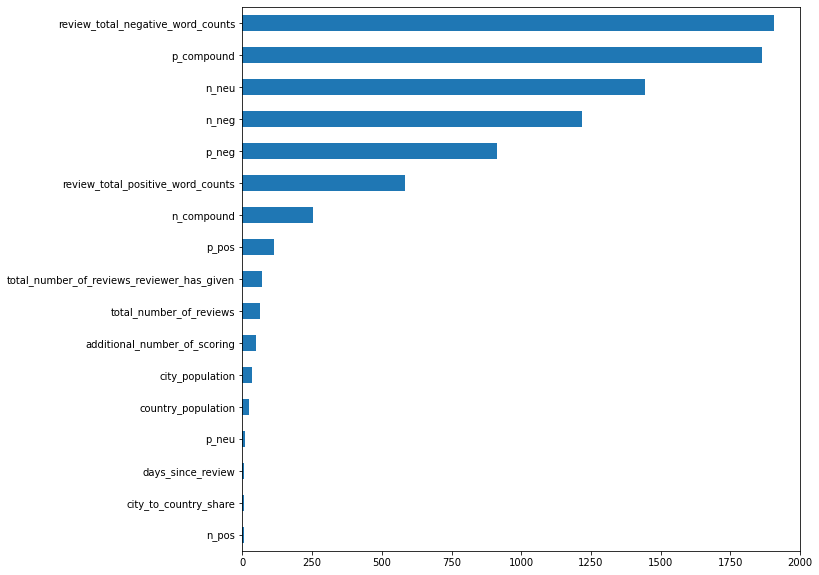

In [709]:
from sklearn.feature_selection import f_classif # anova

plt.rcParams['figure.figsize'] = (10,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [710]:
del_columns = ['n_pos', 'city_to_country_share', 'days_since_review', 'p_neu']

<AxesSubplot:>

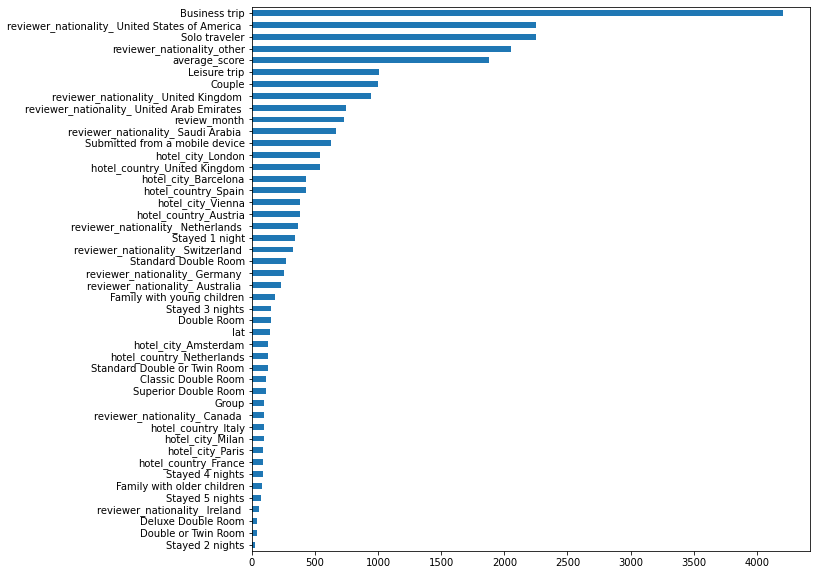

In [711]:
from sklearn.feature_selection import chi2 # хи-квадрат

y=y.astype('int')
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [712]:
# поиск мультиколлениарности
pivot = hotels_r.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis=1)

<AxesSubplot:>

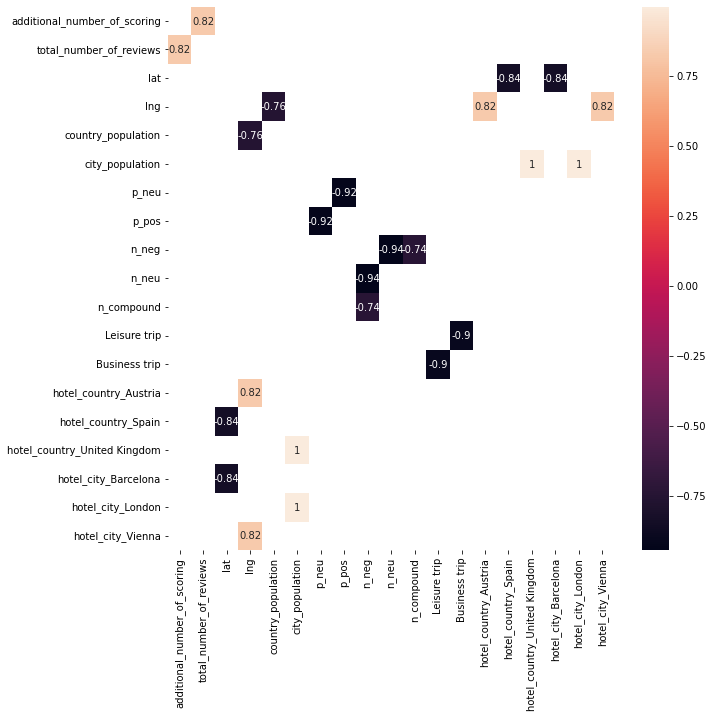

In [713]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(pivot, annot=True)

In [714]:
del_columns.extend(['additional_number_of_scoring', 'lat', 'lng', 'city_population', 'n_neg', 'Leisure trip'])

In [715]:
# удалим колонки, не прошедшие отбор
hotels_r.drop(del_columns, axis=1, inplace=True)

<AxesSubplot:>

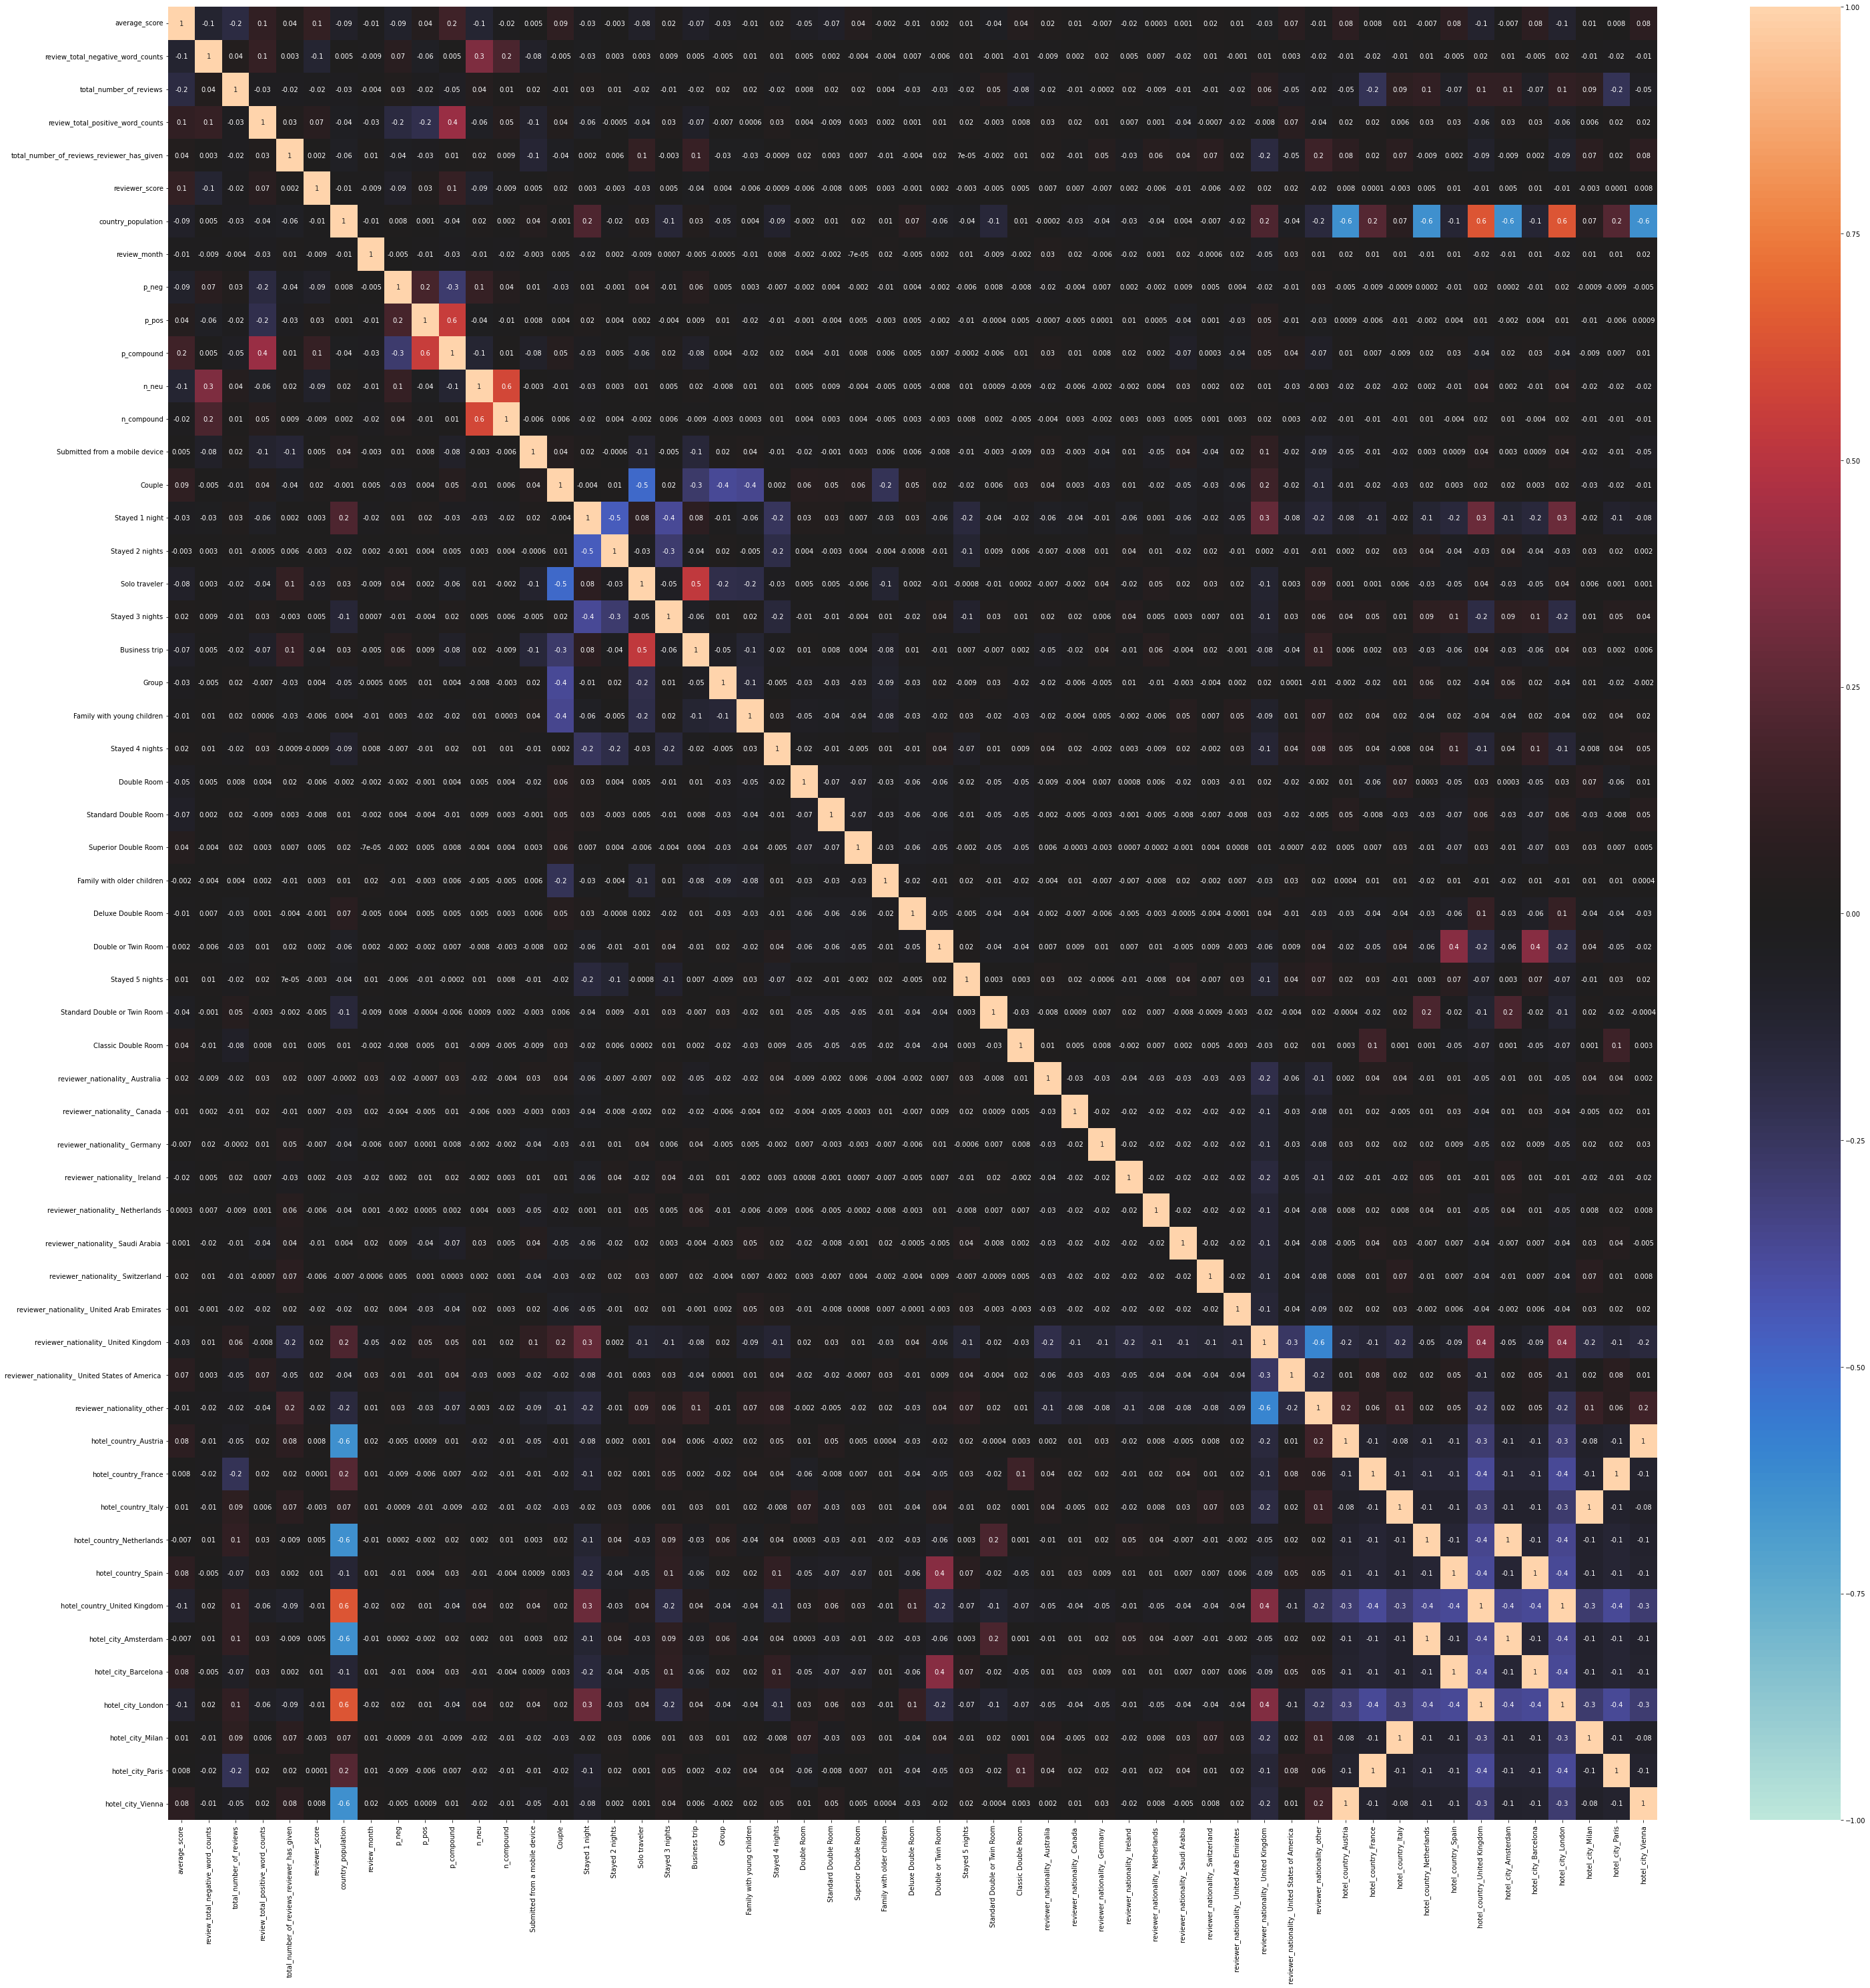

In [716]:
plt.rcParams['figure.figsize'] = (50,50)
sns.heatmap(hotels_r.drop(['sample'], axis=1).corr(), annot=True, vmin=-1, vmax=1, center= 0, fmt='.1g')

В данных отсутствуют признаки с сильной корреляцией, можно переходить к обучению модели.

# 5. Подготовка данных для модели

In [717]:
train_data = hotels_r.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_r.query('sample == 0').drop(['sample'], axis=1)

X = train_data.drop(['reviewer_score'], axis=1)
y = train_data.reviewer_score.values

In [719]:
# разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [720]:
# проверяем размерности получившихся датасетов
train_data.shape, test_data.shape, X.shape, X_train.shape, X_test.shape

((386803, 55), (128935, 55), (386803, 54), (309442, 54), (77361, 54))

In [721]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train) 

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s


MAPE: 0.12493324368856253


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.4s finished


<AxesSubplot:>

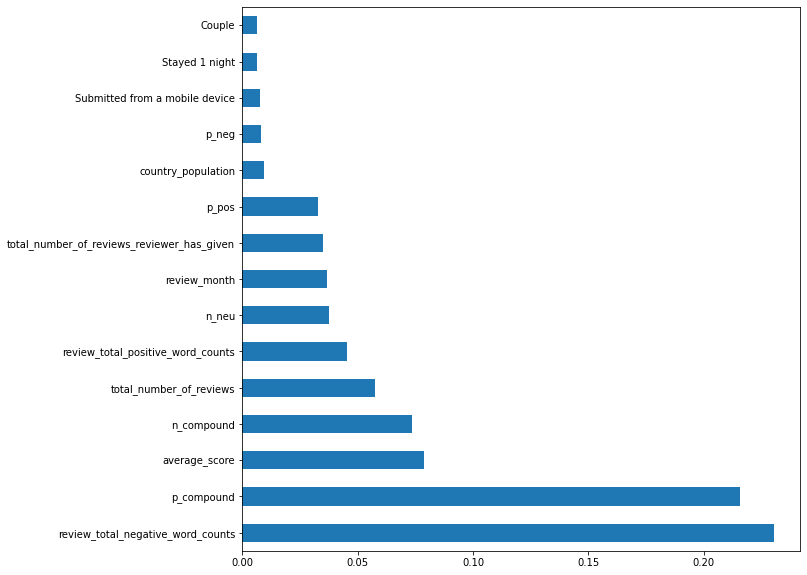

In [722]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [723]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [724]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [725]:
predict_submission = regr.predict(test_data)
predict_submission

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.5s finished


array([8.538, 7.003, 8.967, ..., 8.397, 9.499, 7.022])

In [726]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('final_submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.538,488440
1,7.003,274649
2,8.967,374688
3,9.768,404352
4,9.593,451596
5,9.115,302161
6,8.055,317079
7,7.344,13963
8,8.371,159785
9,7.591,195089
